# Tutorial : Introduction to *ewstools*

By the end of this tutorial you should know how to:
- Initialise a TimeSeries object with your data
- Detrend your data using a specific filter and bandwidth
- Compute CSD-based early warning signals (EWS) over a rolling window
- Measure the trend of the EWS with Kendall tau values
- Visualise output

Further details on each class and function can be found in the [documentation](https://ewstools.readthedocs.io/en/latest/).

Total run time : 2 min 18 s on Macbook Air (M1, 2020)


## Import libraries


In [1]:
# Start timer to record execution time of notebook
import time
start_time = time.time()

In [2]:
import numpy as np
np.random.seed(0) # Set seed for reproducibility
import pandas as pd
import matplotlib.pyplot as plt
import os

import ewstools
from ewstools.models import simulate_ricker

## Initialise a TimeSeries object

Before computing EWS, it is necessary to set up your data inside a TimeSeries object. Your data must be a 1D time series and can take the form of a python list, a numpy array, or a pandas series. In the case of a pandas series, the index of your data will be carried forward throughout the analysis, which is preferable if you don't want arbitrary time points assigned.


For this tutorial, we will use simulation data from the Ricker model going through a Fold bifurcation. There is a collection of functions to simulate various models in [*ewstools.models*](https://ewstools.readthedocs.io/en/latest/ewstools.html#). We will simulate 500 points and increase the harvesting rate from 0 to 2.7 over the course of the trajectory.

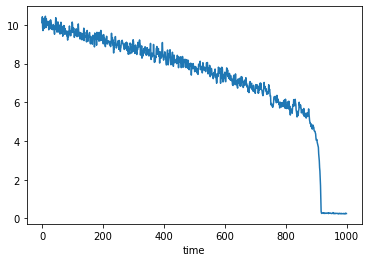

In [3]:
series = simulate_ricker(tmax=1000, F=[0,2.7])
series.plot();

This outputs a pandas Series, which an acceptable form to put into the TimeSeries object.

In [4]:
type(series)

pandas.core.series.Series

Alongside the data, there is the option to specify a transtion time, beyond which any EWS will not be computed. Based on the plot, let's take a conservative transition time of 420. There exist methods to estimate transition times such as change-point detection algorithms, which can be implemented using the Python package [ruptures](https://github.com/deepcharles/ruptures).

In [5]:
# Create TimeSeries object
ts = ewstools.TimeSeries(data=series, transition=840)

The TimeSeries object has several attributes worth knowing about:

| Attribute | Type | Notes |
| :- | :- | :- |
| transition  | float | transition time (if defined) | 
| state  | pd.DataFrame | dataframe containing raw time series data and any detrending | 
| ews  | pd.DataFrame | dataframe containing any EWS computed | 
| ktau  | dict | dictionary containing Kendall tau values | 
| dl_preds  | pd.DataFrame | dataframe containing predictions from deep learning classifiers | 

You can access these attributes by writing *TimeSeries.attribute*.

In [6]:
# E.g. check the defined transtion time
ts.transition

840.0

To begin with, these attributes should all be empty, except for *transition* (if defined) and *state*, where you should see your data. We will display the head of the *state* DataFrame.

In [7]:
ts.state.head()

,state
time,
0,10.108574
1,10.411427
2,9.823899
3,9.699381
4,10.106707


We can plot it using the pandas function *.plot()*:

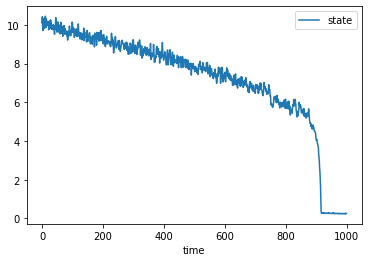

In [8]:
ts.state.plot();

## Detrend the data (if necessary)

You can detrend your data with either a Lowess or a Gaussian filter. You'll need to select a bandwidth (for Gaussian) or a span (for Lowess). Considerations to make when choosing appropriate detrending parameters are given in [Dakos et al. (2012)](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0041010). You can define your bandwidth/span as either an absolute number of data points, or a proportion of the number of data points prior to the transition.

Let's detrend our data using a Lowess filter with a span of 0.2. After applying the method *detrend*() to the TimeSeries class, we will see that the attribute *state* contains the smoothed time series and residuals.

In [9]:
ts.detrend(method='Lowess', span=0.2)
ts.state.head()

,state,smoothing,residuals
time,,,
0,10.108574,10.098202,0.010372
1,10.411427,10.092986,0.318441
2,9.823899,10.087775,-0.263876
3,9.699381,10.082569,-0.383188
4,10.106707,10.077369,0.029338


This can be plotted directly from a pandas DataFrame with the command:

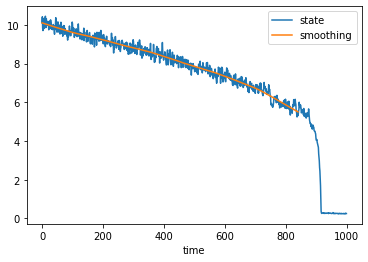

In [10]:
ts.state[['state','smoothing']].plot();

## Compute CSD-based early warning signals (EWS)

There are many time series metrics that can indicate critical slowing down (CSD), thus providing a warning for a bifurcation. We refer to these metrics as CSD-based EWS. They are computed over a rolling window with a size defined by the user. The rolling window can be given as a proporiton of the pre-transition data, or an absolute number of data points. If you chose to detrend, EWS will be computed on the residual data. Otherwise, EWS will be computed on the raw data.

The table below lists the CSD-based EWS that can be computed by *ewstools* and their associated method:

| EWS  | Method | Notes |
| ------------- | ------------- | -------------- |
| variance  | [compute_var( )](https://ewstools.readthedocs.io/en/latest/ewstools.html#ewstools.core.TimeSeries.compute_var)  | Second moment of the data |
| standard deviation | compute_std( ) | Square root of the variance |
| coefficient of variation | comptue_cv( ) | Standard deviation divided by the mean (of the undetrended time series) | 
| skewness | compute_skew( )  | Standardised third moment of the data |
| kurtosis | compute_kurt( )  | Standardised fourth moment of the data |
| lag-tau autocorrelation | compute_ac( lag=tau )  | Correlation between the data and a shifted version (by tau) of itself |

There also exist EWS based on the power spectrum of a time series, however we have saved these for a later tutorial as they require the extra step of computing the power spectrum. Let's compute the variance, lag-1 autocorrelation and skew of our residual data prior to the fold bifurcation:

In [11]:
# Define rolling window length
rw = 0.5
ts.compute_var(rolling_window=rw)
ts.compute_auto(rolling_window=rw, lag=1)
ts.compute_skew(rolling_window=rw)

This will fill up the *ews* attribute of the TimeSeries object. Let's preview the dataframe now, and do a quick plot in pandas matplotlib.

In [12]:
ts.ews.dropna().head()

,variance,ac1,skew
time,,,
419,0.041357,0.309390,0.123536
420,0.041808,0.312752,0.129628
421,0.041630,0.321098,0.128387
422,0.041475,0.316087,0.127936
423,0.041368,0.318582,0.133086


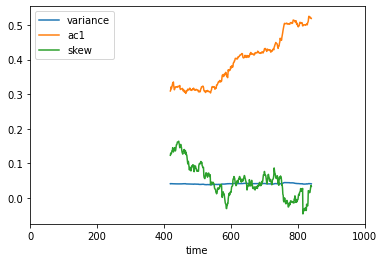

In [13]:
ts.ews.plot(xlim=(0,1000));

## Measure the trend of the EWS with Kendall tau

For this time series, we see roughly increasing trends in the EWS as a result of the critical slowing down phenomena. A useful way to measure the increasing/decreasing tendancy of a trend, is to compute the Kendall tau correlation between the signal and time. Kendall tau values can be computed in *ewstools* with the method [*compute_ktau( )*](https://ewstools.readthedocs.io/en/latest/ewstools.html#ewstools.core.TimeSeries.compute_ktau).

In [14]:
ts.compute_ktau()

Now the *ktau* attribute should be filled with the Kendall tau value for each EWS computed.

In [15]:
ts.ktau

{'variance': 0.30715628553095203,
 'ac1': 0.8100663056815751,
 'skew': -0.5270344812058854}

The positive values indicate increasing trends. Negative values would indicate decreasing trends. A maximal (minimal) Kendall tau value of 1 (-1) indicates that every subsequent point takes a larger (smaller) value.

## Visualise output of *ewstools*

Output of each EWS computed can be visualised with the method [make_plotly( )], which creates an interactive plot in [Plotly](https://plotly.com/). Since we are running this in a Jupyter notebook, this plot can be viewed inline:

In [21]:
fig = ts.make_plotly(kendall_tau=True)
fig.show()

If running a script, the figure can be exported to an html file and viewed in a web browser, with fig.write_html(filepath).

For more flexibility, you may want to make your own figures, e.g. with matplotlib as below or in Plotly itself, documentation for which can be found [here](https://plotly.com/python/).

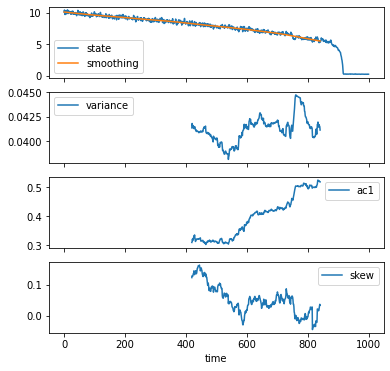

In [23]:
fig1, axes = plt.subplots(nrows=4, ncols=1, figsize=(6,6), sharex=True)
ts.state[['state','smoothing']].plot(ax=axes[0])
ts.ews['variance'].plot(ax=axes[1],legend=True)
ts.ews['ac1'].plot(ax=axes[2],legend=True);
ts.ews['skew'].plot(ax=axes[3],legend=True);